# Import

In [2]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm

import contextlib
from src.preprocessing import apply_transformation

# Data & PCA factors

In [5]:
# FRED
fred_md = pd.read_csv("data/fred_md_2024_12.csv")
fred_md_short = (
    fred_md.iloc[1:]
    .assign(sasdate=pd.to_datetime(fred_md.iloc[1:].sasdate, format="%m/%d/%Y"))
    .set_index("sasdate")
)
fred_info = pd.read_csv("data/FRED_MD_updated_appendix.csv", encoding="latin1")

start_date, end_date = "1960", "2024"

for _, row in fred_info.iterrows():
    series_name = row['fred']
    transformation_code = row['tcode']

    # Apply appropriate transformation to fred df
    with contextlib.suppress(Exception):
        fred_md_short[series_name] = apply_transformation(fred_md_short[series_name], transformation_code)

fred_md_short = fred_md_short[
    (fred_md_short.index >= start_date) & (fred_md_short.index <= end_date)
].dropna(axis=1)

# RECESSION
us_rec = pd.read_csv("data/USREC.csv")
us_rec = us_rec.assign(
    observation_date=pd.to_datetime(us_rec.observation_date)
    ).set_index("observation_date")
us_rec = us_rec.loc[fred_md_short.index,:]

# Sparse factors
factors = pd.read_csv('data/Static_factor/estimated_factor.csv')
factors = factors.assign(sasdate=pd.to_datetime(factors.sasdate)).set_index("sasdate")

# Model Estimation

In [21]:
factors_lagged = factors.shift(1).dropna()

common_index = factors_lagged.index.intersection(us_rec.index)
y = us_rec.loc[common_index]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(factors_lagged, y, test_size=0.2, random_state=42, stratify=y)

logit_model = LogisticRegression(solver='liblinear', max_iter=1000)
logit_model.fit(X_train, y_train.values.ravel())


LogisticRegression(max_iter=1000, solver='liblinear')

# Results

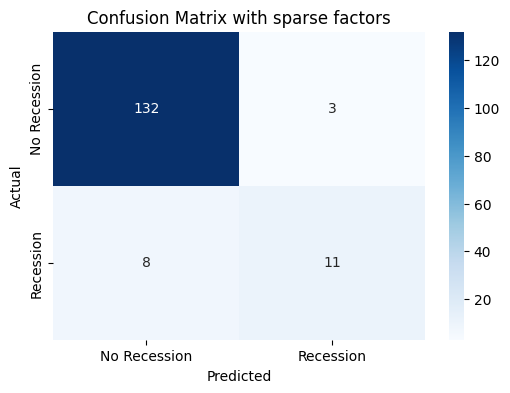

Logit estimated with Bayesian Sparse Factors:
               precision    recall  f1-score   support

           0       0.94      0.98      0.96       135
           1       0.79      0.58      0.67        19

    accuracy                           0.93       154
   macro avg       0.86      0.78      0.81       154
weighted avg       0.92      0.93      0.92       154



In [23]:
y_pred = logit_model.predict(X_test)


# Confusion matrix
plt.figure(figsize=(6, 4))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Recession", "Recession"], yticklabels=["No Recession", "Recession"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix with sparse factors")
plt.show()

# Metrics
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=["No Recession", "Recession"])

print("Logit estimated with Bayesian Sparse Factors:\n", classification_report(y_test, y_pred))